In [1]:
import csv
import time
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import sklearn
import sklearn.tree
import sklearn.ensemble
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler 
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [2]:
def normalize(x):
    '''This function nomalizes each columns of the input 2d array.'''
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x_std[x_std == 0] = 1
    x1 = (x - x_mean) / x_std
    return x1


def addFeature (X_train, X_test1, X_test2, add_feature):
    addFeatureLen = len(add_feature)
    for i1 in range (addFeatureLen):
        for i2 in range (i1,addFeatureLen, 1):
            newFeature1 = np.array(X_train[:,i1]*X_train[:,i2]).reshape(-1,1)
            #print (np.shape(newFeature1))
            X_train = np.hstack((X_train, newFeature1))
            newFeature2 = np.array(X_test1[:,i1]*X_test1[:,i2]).reshape(-1,1)
            X_test1 = np.hstack((X_test1, newFeature2))
            newFeature3 = np.array(X_test2[:,i1]*X_test2[:,i2]).reshape(-1,1)
            X_test2 = np.hstack((X_test2, newFeature3))
    return (X_train, X_test1, X_test2)

#select features using lasso
def selectFeature(X_train, y_train, X_test1, X_test2, alpha1):
    '''This function select the features of normalized data (i.e., np.std(X[:,j]) = 1 or 0).
    Firstly Lasso regression will used to fit the data 'X_train, y_train', the column X[:,j]
    will be selected if wj > 0.'''
    lasso = linear_model.Lasso(alpha=alpha1)
    lasso.fit(X_train, y_train)
    cols = (abs(lasso.coef_) > 0)
    x_train = X_train[:, cols]
    x_test1 = X_test1[:, cols]
    x_test2 = X_test2[:, cols]
    str1 = 'The regularization alpha in the Lasso regression is %.6f ; '
    str2 = ' %d features have been selected.'
    print(str1 % alpha1, str2 % sum(cols))
    return (x_train, x_test1, x_test2)

# load the the data from the files
with open('train_2008.csv', 'r') as file1: 
    lines1 = csv.reader(file1, delimiter=',', quotechar='|') 
    next(lines1, None)
    data1 = np.array([line for line in lines1], dtype=float)

with open('test_2008.csv', 'r') as file2:
	lines2 = csv.reader(file2, delimiter=',', quotechar='"')
	next(lines2, None)
	data2 = np.array([line for line in lines2], dtype=float)

with open('test_2012.csv', 'r') as file3:
	lines3 = csv.reader(file3, delimiter=',', quotechar='"')
	next(lines3, None)
	data3 = np.array([line for line in lines3], dtype=float)


# convert the data to float numpy array 
alpha1 = 0.0075
#add_feature = [6,7,39,41,48,57,64,371,374];
#add_feature = [8, 17, 26, 30, 31, 43, 92, 135]
N_train = len(data1)
y_train = 2 * (data1[:, -1] - 1.5)  # maps 1 to -1, 2 to 1
X_train = normalize(data1[:, :-1])
X_train[:, 0] = 1
X_test1 = normalize(data2)
X_test1[:, 0] = 1
X_test2 = normalize(data3)
X_test2[:, 0] = 1
#qmin, qmax = 1, 100
#X_train, X_test1, X_test2 = addFeature(X_train, X_test1, X_test2, add_feature)
X_train, X_test1, X_test2 = selectFeature(X_train, y_train, X_test1, X_test2, alpha1) 

d = len(X_train[0])
print (d)





The regularization alpha in the Lasso regression is 0.007500 ;   68 features have been selected.
68


In [37]:

# train the model and calculate the scores by cross-validation
N = 200
clf1 = AdaBoostClassifier(n_estimators=N)
clf2 = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, 
                                  n_estimators=180, subsample=0.8, 
                                  criterion='friedman_mse', min_samples_split=10, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                  max_depth=3, min_impurity_split=1e-07, init=None, 
                                  random_state=None, max_features=None, verbose=0, 
                                  max_leaf_nodes=None, warm_start=False, presort='auto')
clf3 = RandomForestClassifier(n_estimators=N, min_samples_split=2, max_depth=10, oob_score=True)
clf4 = xgb.XGBClassifier(max_depth=4, silent = 1, objective = 'binary:logistic')
eclf = VotingClassifier(estimators=[('gb', clf2), ('xgb', clf4)], voting='hard')
clf_lst = [clf2,clf4,eclf]
name_lst = ['GradientBoost', 'XGBoost', 'voting']
"""for clf, name in zip(clf_lst, name_lst):
    scores = cross_val_score(clf, X_train, y_train, cv=2, scoring='accuracy')
    print("Accuracy: %0.6f (+/- %0.6f) [%s]" % (scores.mean(), scores.std(), name))"""




'for clf, name in zip(clf_lst, name_lst):\n    scores = cross_val_score(clf, X_train, y_train, cv=2, scoring=\'accuracy\')\n    print("Accuracy: %0.6f (+/- %0.6f) [%s]" % (scores.mean(), scores.std(), name))'

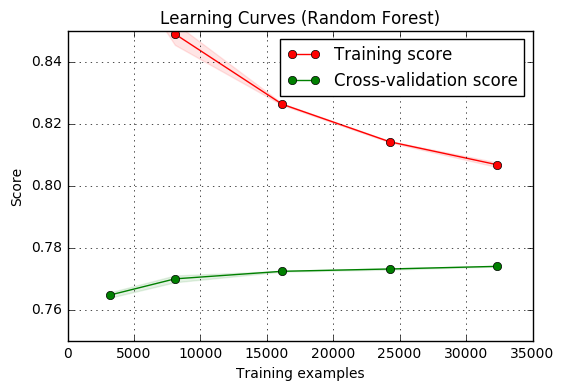

In [38]:
title = "Learning Curves (Random Forest)"
randomforestplt = plot_learning_curve(clf3, title, X_train, y_train, ylim = (0.75, 0.85), cv=2, n_jobs=1)

randomforestplt.savefig('randomforest.png')
randomforestplt.show()

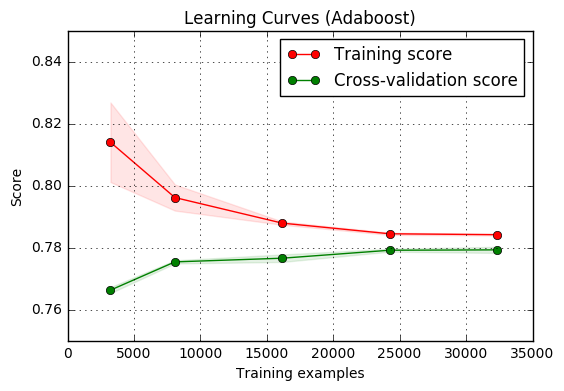

In [18]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.array([0.1,0.25,0.5,0.75, 1])):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt





title = "Learning Curves (Adaboost)"

adaboostplt = plot_learning_curve(clf1, title, X_train, y_train, ylim = (0.75, 0.85), cv=2, n_jobs=1)

adaboostplt.savefig('Adaboost.png')
adaboostplt.show()


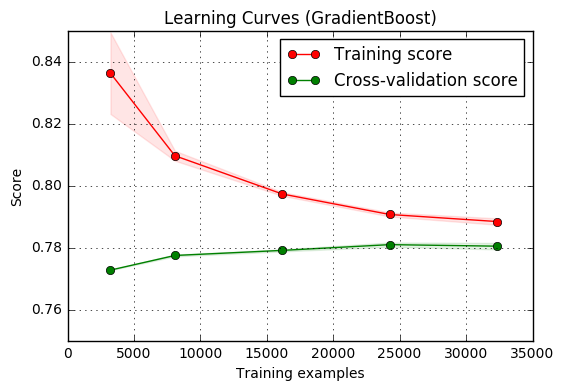

In [19]:
title = "Learning Curves (GradientBoost)"
gradientboostplt = plot_learning_curve(clf2, title, X_train, y_train,  ylim = (0.75, 0.85), cv=2, n_jobs=1)

gradientboostplt.savefig('gradientboost.png')
gradientboostplt.show()

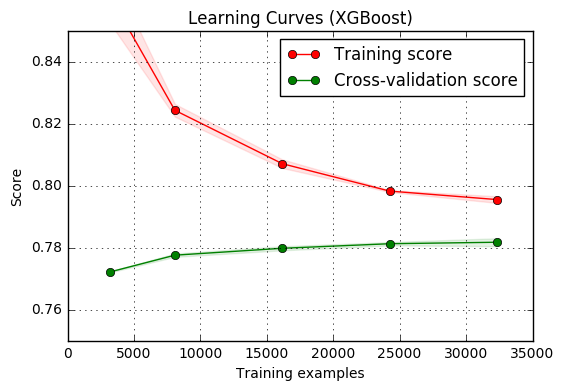

In [21]:
title = "Learning Curves (XGBoost)"
xgboostplt = plot_learning_curve(clf4, title, X_train, y_train,  ylim = (0.75, 0.85), cv=2, n_jobs=1)

xgboostplt.savefig('XGBoost.png')
xgboostplt.show()

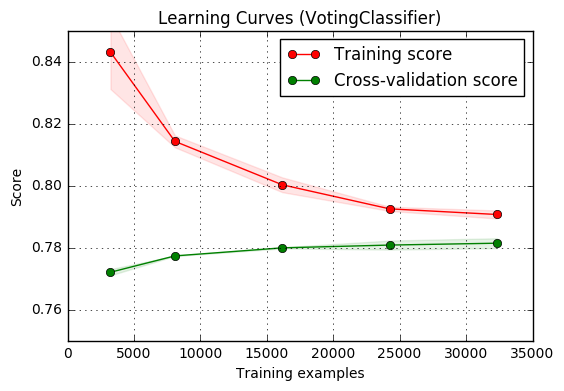

In [39]:
title = "Learning Curves (VotingClassifier)"
voteplt = plot_learning_curve(eclf, title, X_train, y_train,  ylim = (0.75, 0.85), cv=2, n_jobs=1)

voteplt.savefig('votingclassifier.png')
voteplt.show()

In [48]:

# write the prediction data into the submission file
eclf.fit(X_train, y_train)
y_test1 = eclf.predict(X_test1)
print([sum(y_test1==-1), sum(y_test1==1)])
with open('submission2008.csv', 'w', newline='') as file: 
	filewriter = csv.writer(file, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
	filewriter.writerow(['id', 'PES1'])
	for i, yi in enumerate(y_test1):
		filewriter.writerow([str(i), str(int(yi/2 + 1.5))])
y_test2 = eclf.predict(X_test2)
print([sum(y_test2==-1), sum(y_test2==1)])
with open('submission2012.csv', 'w', newline='') as file: 
	filewriter = csv.writer(file, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
	filewriter.writerow(['id', 'PES1'])
	for i, yi in enumerate(y_test2):
		filewriter.writerow([str(i), str(int(yi/2 + 1.5))])


[14121, 1879]
[73190, 9630]
